In [1]:
import pandas as pd
import matplotlib.pylab as plt
import urllib.request, json 
from datetime import datetime
import numpy as np
import itertools

FILENAME = 'https://covid19.compute.dtu.dk/data/telco_map_new.json'

In [2]:
with urllib.request.urlopen(FILENAME) as url:
    data = json.loads(url.read().decode())


# Transform to a dataframe

In [3]:
def dict2wide(data):
    ds = []
    for key in data.keys():
        if key!='_meta':
            d = pd.DataFrame.from_dict(data[key],orient='index')
            d = pd.concat([d], keys=[key], names=['origin','destination'])
        ds.append(d)
    data_wide = pd.concat(ds)
    data_wide.columns = [datetime.fromisoformat(date_string) for date_string in data['_meta']['datetime']]
    return data_wide.reset_index()

data_wide = dict2wide(data)
data_wide.head()

,origin,destination,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,...,2021-06-21 00:00:00,2021-06-22 00:00:00,2021-06-23 00:00:00,2021-06-24 00:00:00,2021-06-25 00:00:00,2021-06-26 00:00:00,2021-06-27 00:00:00,2021-06-28 00:00:00,2021-06-29 00:00:00,2021-06-30 00:00:00
0,Aabenraa,Aabenraa,646324,590656,777948,809334,815630,847670,835820,619796,...,1066700.0,1150800.0,1163864.0,1167784.0,1173010.0,843462.0,698940.0,1069312.0,1144922.0,1155374.0
1,Aabenraa,_Aabenraa,829561,738094,978612,1012792,1022912,1070101,1099371,807903,...,1323574.0,1430844.0,1444552.0,1436034.0,1441603.0,1048804.0,853570.0,1330700.0,1418198.0,1437307.0
2,Aabenraa,Aalborg,591,542,264,200,195,305,505,591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aabenraa,Allerød,6,16,8,0,0,22,72,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aabenraa,Assens,1414,1215,760,820,510,775,1579,1639,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data_long = pd.melt(data_wide, ['origin','destination'], var_name="date", value_name="counts")
data_long.head()

,origin,destination,date,counts
0,Aabenraa,Aabenraa,2020-02-01,646324.0
1,Aabenraa,_Aabenraa,2020-02-01,829561.0
2,Aabenraa,Aalborg,2020-02-01,591.0
3,Aabenraa,Allerød,2020-02-01,6.0
4,Aabenraa,Assens,2020-02-01,1414.0


# Plot a timeline

In [5]:
origin_dest_mask = (data_long.origin=='København') & (data_long.destination=='Frederiksberg')
timeseries = data_long.loc[ origin_dest_mask, ["date", "counts"] ].set_index("date")
timeseries.head()

,counts
date,
2020-02-01,461416.0
2020-02-02,395666.0
2020-02-03,548034.0
2020-02-04,579782.0
2020-02-05,577195.0


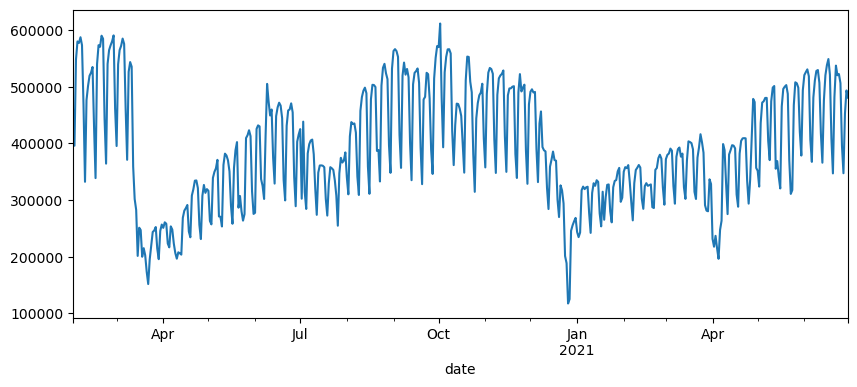

In [6]:
fig, ax = plt.subplots(figsize = (10,4))
timeseries.plot(ax=ax, legend=False)
plt.show()

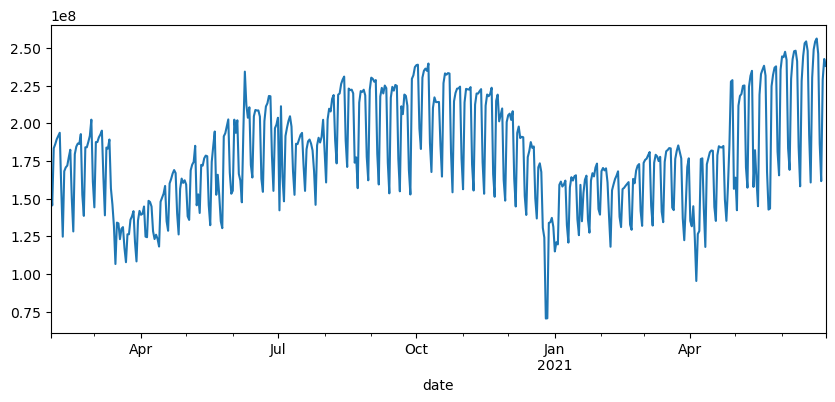

In [7]:
aggregated_data = data_long.groupby(["date"]).sum()
fig, ax = plt.subplots(figsize = (10,4))
aggregated_data.plot(ax=ax, legend=False)
plt.show()

# Directed data

In [8]:
FILENAME = 'https://covid19.compute.dtu.dk/data/telco_data.json'
with urllib.request.urlopen(FILENAME) as url:
    rawdata = json.loads(url.read().decode())

In [9]:
data = np.array(rawdata['data'])
locations = rawdata['locations']
dates = [datetime.fromisoformat(d) for d in rawdata['dates']]

  - data     : num [1:9604, 1:516] 323162 405 0 0 690 ...
  - locations: chr [1:98] "Aabenraa" "Aalborg" "Albertslund" "Allerød" ...
  - dates    : chr [1:516] "2020-02-01 00:00:00" "2020-02-02 00:00:00" "2020-02-03 00:00:00" "2020-02-04 00:00:00" ...
  
`data` is a matrix with columns corresponding to dates and rows corresponding to each unique origin-destination combination (location[1] -> location[1], location[1] -> location[2], location[1] -> location[3] … location[2] -> location[1], location[2] -> location[2] …)

In [10]:
##ALL ORIGIN DESTINATION PAIRS
origin_destination_pairs = np.array(list(itertools.product(locations, repeat=2)))

##CONCATENATE WITH VALUES
all_data = np.concatenate([origin_destination_pairs, data], axis=1, dtype='object')

##BUILD DATAFRAME
columns = ['origin','destination']+[datetime.fromisoformat(date_string) for date_string in rawdata['dates']]
data_long = pd.DataFrame(all_data,columns=columns).set_index(['origin','destination']).stack().reset_index()
data_long.columns = ['origin','destination','date','counts']
data_long.head()

,origin,destination,date,counts
0,Aabenraa,Aabenraa,2020-02-01,323162.099102
1,Aabenraa,Aabenraa,2020-02-02,295328.638037
2,Aabenraa,Aabenraa,2020-02-03,388974.404547
3,Aabenraa,Aabenraa,2020-02-04,404667.087491
4,Aabenraa,Aabenraa,2020-02-05,407815.830703


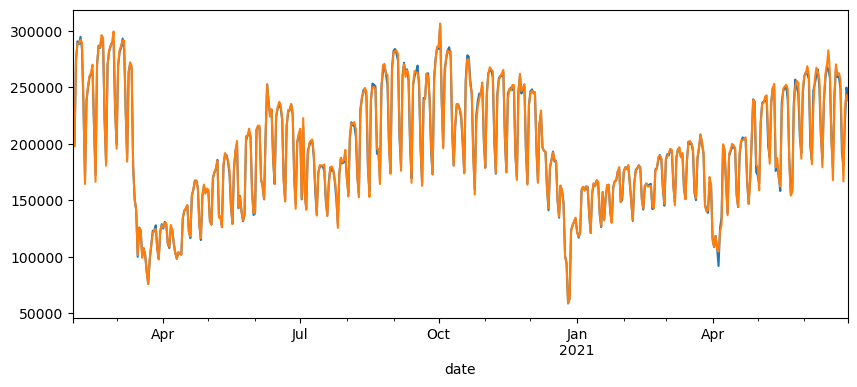

In [11]:
fig, ax = plt.subplots(figsize = (10,4))
data_long[(data_long.origin=='København') & (data_long.destination=='Frederiksberg')].set_index('date').plot(ax=ax,legend=False)
data_long[(data_long.origin=='Frederiksberg') & (data_long.destination=='København')].set_index('date').plot(ax=ax,legend=False)
plt.show()

In [12]:
num_locations = np.size(rawdata['locations'])
num_dates = np.size(dates)
data_3d = np.reshape(rawdata['data'], (num_locations, num_locations, num_dates))
np.shape(data_3d)

(98, 98, 516)

# Build the network on a specific date

In [13]:
date_mask = data_long.date == datetime(2020,3,1)
edgelist = data_long.loc[ date_mask, ["origin", "destination", "counts"] ].reset_index(drop=True)
edgelist.head()

,origin,destination,counts
0,Aabenraa,Aabenraa,292006.382233
1,Aabenraa,Aalborg,333.618773
2,Aabenraa,Albertslund,29.854029
3,Aabenraa,Allerød,5.224455
4,Aabenraa,Assens,610.77992


In [14]:
from graph_tool import *
import graph_tool.inference as gi
import graph_tool.draw as gd

### init graph

In [15]:
g = Graph()
g.add_vertex(num_locations)

<generator object Graph.add_vertex.<locals>.<genexpr> at 0x7f4553d67040>

### add edges

In [16]:
nodes = range(num_locations)
for i in nodes:
    for j in nodes:
        g.add_edge(i,j)

### add weights

In [17]:
k = 0
g.edge_properties["counts"] = counts = g.new_edge_property("double") 
for i in nodes:
    for j in nodes:
        e = g.edge(i,j)
        counts[e] = edgelist.counts[k]
        k += 1

### thin out

In [18]:
threshold = np.percentile(counts.get_array(), 90)

In [19]:
keep = g.new_edge_property("bool")
for e in g.edges():
    keep[e] = counts[e] > threshold
g.set_edge_filter(keep)

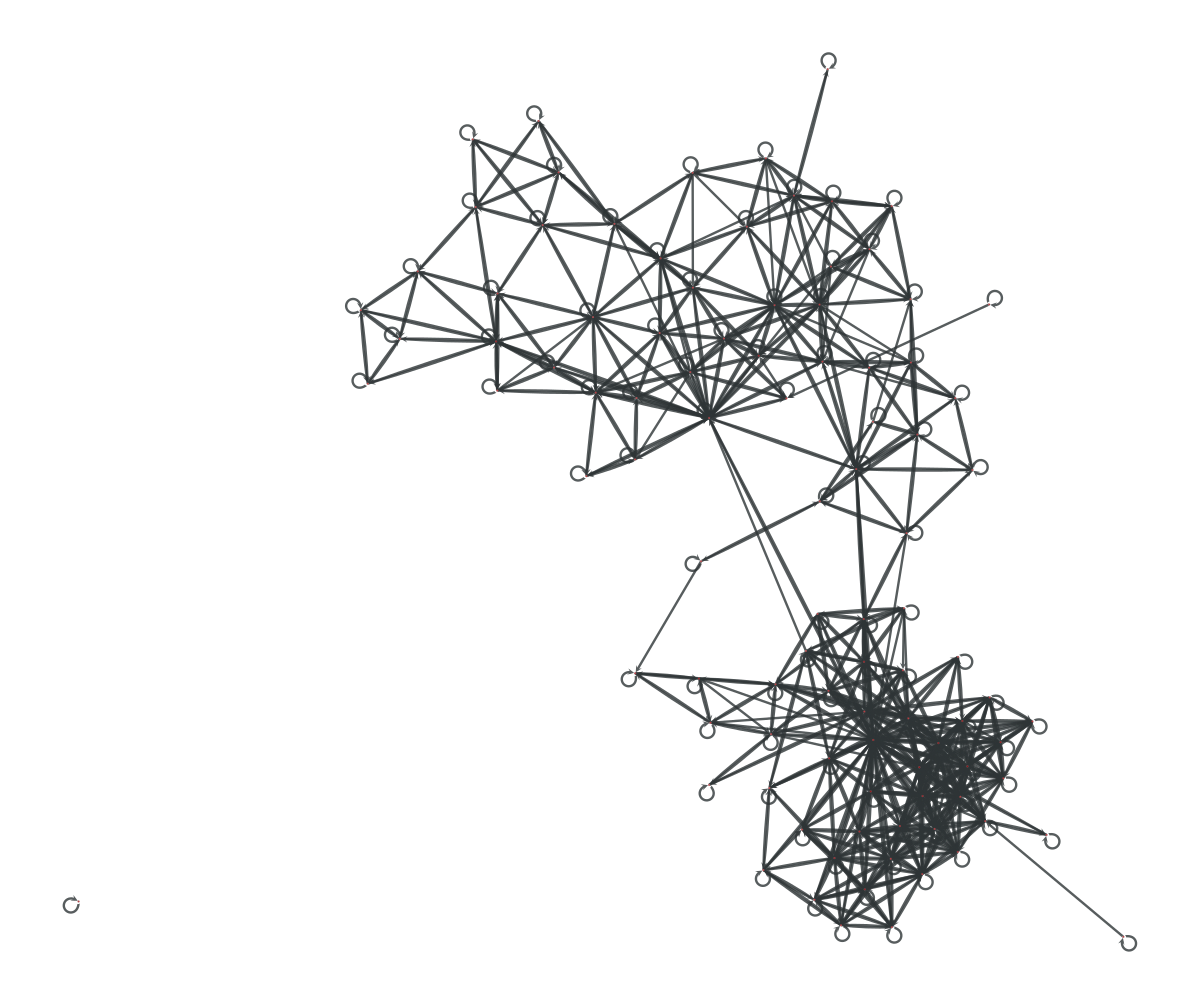

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f45531e1190, at 0x7f455320d4c0>

In [20]:
pos = gd.sfdp_layout(g)
gd.graph_draw(g, pos, vertex_size=1, edge_pen_width=1.2)

### analyze network structure

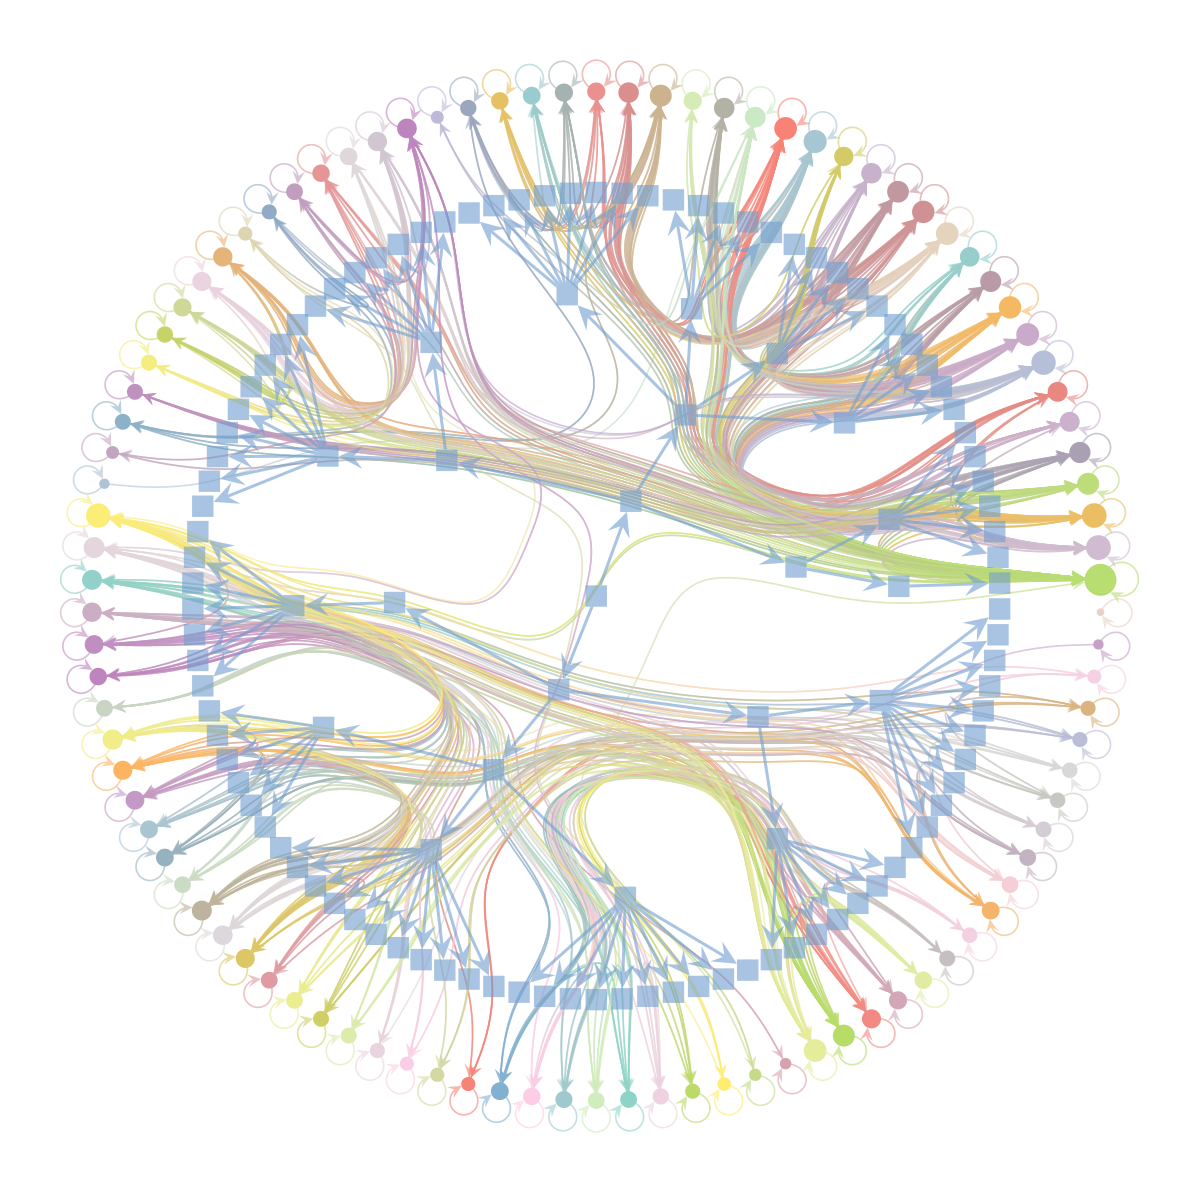

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f45531e1190, at 0x7f44fca52190>,
 <Graph object, directed, with 219 vertices and 218 edges, at 0x7f44fca4a880>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f44fca4a880, at 0x7f44fca50640>)

In [21]:
state = gi.minimize_nested_blockmodel_dl(g, state_args=dict(recs=[g.ep.counts],
                                                            rec_types=["discrete-binomial"]))
state.draw()